In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
def df_to_X_y(df,hoursToPredict, window_size):
        hoursToPredict = hoursToPredict - 1
        df_as_np = df.to_numpy() # converts the dataframe to a numpy array
        #Initialized  arrays to append X and Y values 
        X = []
        y = []
        for i in range(len(df_as_np)):
            if((i + hoursToPredict + window_size)< len(df_as_np)):
                #Takes values from i to i + win size
                row =  [r for r in df_as_np[i:i+window_size]]
                X.append(row)
                label = df_as_np[i + hoursToPredict + window_size ][0]
                y.append(label)
        return np.array(X), np.array(y)

In [10]:
def DataHandler(hoursToPredict,window_size):
    D003_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D003_data.csv')
    D003_df = pd.DataFrame(D003_df)
    D003_df['time'] =  pd.to_datetime(D003_df['time'], format='%Y-%m-%d %H:%M:%S')
    D003_df.index = D003_df['time']
    D003_df = D003_df.drop(['time'],axis = 1)
    
    X1, y1 = df_to_X_y(D003_df,hoursToPredict,window_size)

    return X1, y1

In [11]:
plt.style.use('seaborn')

In [12]:
def Trainer(time):
    window_size =  6
    while(window_size <= 12):
        model = Sequential()
        model.add(InputLayer((window_size, 5)))
        model.add(LSTM(64))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,window_size)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
        
#         X_train, y_train = X[:92508], y[:92508] # training data
#         X_val, y_val = X[92508:95508], y[92508:95508] #validation
#         X_test, y_test = X[95508:], y[95508:] #test
        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
        
        cp1= ModelCheckpoint(str(time)+"H_ForecastModel_"+str(window_size)+"_SizeWindow/", save_best_only=True)
        model.compile(loss=MeanSquaredError(), 
                   optimizer=Adam(learning_rate=0.0001), 
                   metrics=[MeanAbsoluteError()])
    
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, callbacks=[cp1])
        window_size += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

    window_size = 6 #reset

In [13]:
def modelsEvaluator(time,startWindow,endWindow,jumpOneWindow):
    while(startWindow <= endWindow):
        X, y = DataHandler(time,startWindow)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
#         X_train, y_train = X[:92508], y[:92508] # training data
#         X_val, y_val = X[92508:95508], y[92508:95508] #validation
#         X_test, y_test = X[95508:], y[95508:] #test
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
       
        print("Loading: "+ str(time)+"H_ForecastModel_"+str(startWindow)+"_SizeWindow/")
        model = load_model(str(time)+"H_ForecastModel_"+str(startWindow)+"_SizeWindow/")
        model.evaluate(X_test,y_test)
        
        test_predictions = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions '+str(time) + ' hour model':test_predictions, 'Actuals':y_test})
        
        print('\n')
        if(jumpOneWindow):
            startWindow += 2
        else:
            startWindow += 1

In [14]:
%%time

Trainer(1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 5s 8ms/step - loss: 867.5735 - mean_absolute_error: 29.2705 - val_loss: 771.3952 - val_mean_absolute_error: 27.6038
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 2s 6ms/step - loss: 642.5267 - mean_absolute_error: 25.1162 - val_loss: 530.0786 - val_mean_absolute_error: 22.8072
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 2s 5ms/step - loss: 463.9427 - mean_absolute_error: 21.2822 - val_loss: 399.5987 - val_mean_absolute_error: 19.7153
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 2s 6ms/step - loss: 345.6976 - mean_absolute_error: 18.2797 - val_loss: 292.8582 - val_mean_absolute_error: 16.7896
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 2s 6ms/step - loss: 253.6133 - mean_absolute_error: 15.5599 - val_loss: 217.2538 - val_mean_absolute_error: 14.3624
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 7ms/step - loss: 185.5302 - mean_absolute_error: 13.1958 - val_loss: 156.0759 - val_mean_absolute_error: 12.0458
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 2s 6ms/step - loss: 130.7314 - mean_absolute_error: 10.9249 - val_loss: 107.5389 - val_mean_absolute_error: 9.8268 mean_absol
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 2s 5ms/step - loss: 88.1708 - mean_absolute_error: 8.7732 - val_loss: 70.8016 - val_mean_absolute_error: 7.7464
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 2s 6ms/step - loss: 56.9559 - mean_absolute_error: 6.8045 - val_loss: 44.8531 - val_mean_absolute_error: 5.8946
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 2s 6ms/step - loss: 35.7335 - mean_absolute_error: 5.1192 - val_loss: 28.0725 - val_mean_absolute_error: 4.4158
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 2s 5ms/step - loss: 21.8192 - mean_absolute_error: 3.7862 - val_loss: 16.8105 - val_mean_absolute_error: 3.2634
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 2s 5ms/step - loss: 14.3954 - mean_absolute_error: 3.0127 - val_loss: 12.5998 - val_mean_absolute_error: 2.8325
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 2s 5ms/step - loss: 11.5895 - mean_absolute_error: 2.7441 - val_loss: 10.9042 - val_mean_absolute_error: 2.6826
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 2s 6ms/step - loss: 10.4662 - mean_absolute_error: 2.6475 - val_loss: 9.8095 - val_mean_absolute_error: 2.5654
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 2s 6ms/step - loss: 9.1082 - mean_absolute_error: 2.4537 - val_loss: 8.4920 - val_mean_absolute_error: 2.3669
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 2s 6ms/step - loss: 8.0360 - mean_absolute_error: 2.2864 - val_loss: 7.5157 - val_mean_absolute_error: 2.1993
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 2s 6ms/step - loss: 7.0814 - mean_absolute_error: 2.1340 - val_loss: 6.2367 - val_mean_absolute_error: 1.9852
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 2s 6ms/step - loss: 5.6240 - mean_absolute_error: 1.8731 - val_loss: 4.8430 - val_mean_absolute_error: 1.7363
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 2s 5ms/step - loss: 3.7752 - mean_absolute_error: 1.4882 - val_loss: 2.7316 - val_mean_absolute_error: 1.2175
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 2s 6ms/step - loss: 2.3472 - mean_absolute_error: 1.1214 - val_loss: 1.9374 - val_mean_absolute_error: 1.0283
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 2s 6ms/step - loss: 1.7427 - mean_absolute_error: 0.9575 - val_loss: 1.4205 - val_mean_absolute_error: 0.8733 1.7320 - mean_absolute_error: 0.955
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 2s 5ms/step - loss: 1.3734 - mean_absolute_error: 0.8503 - val_loss: 1.1283 - val_mean_absolute_error: 0.7861
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 7ms/step - loss: 1.0965 - mean_absolute_error: 0.7582 - val_loss: 0.8801 - val_mean_absolute_error: 0.6958
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 2s 5ms/step - loss: 0.8433 - mean_absolute_error: 0.6527 - val_loss: 0.6795 - val_mean_absolute_error: 0.6055
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 2s 5ms/step - loss: 0.6973 - mean_absolute_error: 0.5878 - val_loss: 0.5604 - val_mean_absolute_error: 0.5472
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 4s 7ms/step - loss: 851.0687 - mean_absolute_error: 28.9561 - val_loss: 721.3241 - val_mean_absolute_error: 26.6781
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 2s 6ms/step - loss: 578.7216 - mean_absolute_error: 23.7959 - val_loss: 444.1701 - val_mean_absolute_error: 20.8493
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 2s 6ms/step - loss: 331.2688 - mean_absolute_error: 17.8540 - val_loss: 236.1116 - val_mean_absolute_error: 15.0405
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 2s 5ms/step - loss: 166.6026 - mean_absolute_error: 12.4043 - val_loss: 105.8615 - val_mean_absolute_error: 9.7694
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 7ms/step - loss: 71.7686 - mean_absolute_error: 7.7417 - val_loss: 46.3796 - val_mean_absolute_error: 6.0436
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 2s 6ms/step - loss: 31.6538 - mean_absolute_error: 4.7298 - val_loss: 21.2519 - val_mean_absolute_error: 3.7375
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 2s 6ms/step - loss: 16.2774 - mean_absolute_error: 3.2208 - val_loss: 12.6935 - val_mean_absolute_error: 2.8543
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 2s 6ms/step - loss: 11.0197 - mean_absolute_error: 2.6920 - val_loss: 9.7945 - val_mean_absolute_error: 2.5480
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 2s 6ms/step - loss: 8.9157 - mean_absolute_error: 2.4131 - val_loss: 8.1122 - val_mean_absolute_error: 2.3004
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 2s 6ms/step - loss: 7.8345 - mean_absolute_error: 2.2642 - val_loss: 7.3745 - val_mean_absolute_error: 2.1891
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 2s 6ms/step - loss: 7.1453 - mean_absolute_error: 2.1429 - val_loss: 7.0399 - val_mean_absolute_error: 2.1335
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 2s 6ms/step - loss: 6.7349 - mean_absolute_error: 2.0723 - val_loss: 6.4012 - val_mean_absolute_error: 2.02772 - mean_absolute_error: 2
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 8ms/step - loss: 6.1929 - mean_absolute_error: 1.9836 - val_loss: 5.9559 - val_mean_absolute_error: 1.9489
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 2s 6ms/step - loss: 5.7824 - mean_absolute_error: 1.9141 - val_loss: 5.7187 - val_mean_absolute_error: 1.9122
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 2s 6ms/step - loss: 5.3436 - mean_absolute_error: 1.8404 - val_loss: 5.1158 - val_mean_absolute_error: 1.8010
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 7ms/step - loss: 4.7867 - mean_absolute_error: 1.7359 - val_loss: 4.5214 - val_mean_absolute_error: 1.6929
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 2s 6ms/step - loss: 4.1157 - mean_absolute_error: 1.6097 - val_loss: 3.9185 - val_mean_absolute_error: 1.5656
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 2s 6ms/step - loss: 3.4221 - mean_absolute_error: 1.4564 - val_loss: 3.1472 - val_mean_absolute_error: 1.3864
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 7ms/step - loss: 2.7444 - mean_absolute_error: 1.2791 - val_loss: 2.4484 - val_mean_absolute_error: 1.1931
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 2s 6ms/step - loss: 1.9429 - mean_absolute_error: 1.0504 - val_loss: 1.4985 - val_mean_absolute_error: 0.9002
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 7ms/step - loss: 1.3189 - mean_absolute_error: 0.8486 - val_loss: 1.1997 - val_mean_absolute_error: 0.7907
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0265 - mean_absolute_error: 0.7425 - val_loss: 0.8804 - val_mean_absolute_error: 0.6671loss: 1.0285 - mean_absolute_error: 0.74
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 2s 6ms/step - loss: 0.7810 - mean_absolute_error: 0.6336 - val_loss: 0.7537 - val_mean_absolute_error: 0.6188: 1s - loss: 0.9231 
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 2s 7ms/step - loss: 0.6709 - mean_absolute_error: 0.5861 - val_loss: 0.6519 - val_mean_absolute_error: 0.5758
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 2s 6ms/step - loss: 0.6063 - mean_absolute_error: 0.5595 - val_loss: 0.5913 - val_mean_absolute_error: 0.5329
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 6s 9ms/step - loss: 892.9409 - mean_absolute_error: 29.7034 - val_loss: 829.4512 - val_mean_absolute_error: 28.6337
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 7ms/step - loss: 723.8374 - mean_absolute_error: 26.7000 - val_loss: 624.6453 - val_mean_absolute_error: 24.7837
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 2s 7ms/step - loss: 544.4689 - mean_absolute_error: 23.0849 - val_loss: 467.4447 - val_mean_absolute_error: 21.3721
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 2s 7ms/step - loss: 402.8203 - mean_absolute_error: 19.7790 - val_loss: 340.7898 - val_mean_absolute_error: 18.1649
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 7ms/step - loss: 287.8984 - mean_absolute_error: 16.6166 - val_loss: 236.4173 - val_mean_absolute_error: 15.0160
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 7ms/step - loss: 195.1635 - mean_absolute_error: 13.5421 - val_loss: 154.4861 - val_mean_absolute_error: 11.9812
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 7ms/step - loss: 123.4031 - mean_absolute_error: 10.5700 - val_loss: 93.5342 - val_mean_absolute_error: 9.0896
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 7ms/step - loss: 72.3688 - mean_absolute_error: 7.8179 - val_loss: 52.6935 - val_mean_absolute_error: 6.5097
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 7ms/step - loss: 40.0456 - mean_absolute_error: 5.4893 - val_loss: 28.7359 - val_mean_absolute_error: 4.4858
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 8ms/step - loss: 22.4414 - mean_absolute_error: 3.8561 - val_loss: 17.0340 - val_mean_absolute_error: 3.2935
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 7ms/step - loss: 14.5946 - mean_absolute_error: 3.0558 - val_loss: 12.5210 - val_mean_absolute_error: 2.8492
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 2s 6ms/step - loss: 11.8514 - mean_absolute_error: 2.8029 - val_loss: 11.2228 - val_mean_absolute_error: 2.7488
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 2s 6ms/step - loss: 10.9344 - mean_absolute_error: 2.7224 - val_loss: 9.2979 - val_mean_absolute_error: 2.4625
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 2s 7ms/step - loss: 8.6318 - mean_absolute_error: 2.3658 - val_loss: 7.8103 - val_mean_absolute_error: 2.2480
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 7ms/step - loss: 7.3898 - mean_absolute_error: 2.1818 - val_loss: 6.8222 - val_mean_absolute_error: 2.1051
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 7ms/step - loss: 6.5412 - mean_absolute_error: 2.0488 - val_loss: 6.2534 - val_mean_absolute_error: 2.0084
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 7ms/step - loss: 5.8858 - mean_absolute_error: 1.9412 - val_loss: 5.4610 - val_mean_absolute_error: 1.8710
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 7ms/step - loss: 5.1486 - mean_absolute_error: 1.8103 - val_loss: 4.8175 - val_mean_absolute_error: 1.7544
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 7ms/step - loss: 4.3305 - mean_absolute_error: 1.6401 - val_loss: 3.5278 - val_mean_absolute_error: 1.4703
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 2s 6ms/step - loss: 3.1373 - mean_absolute_error: 1.3645 - val_loss: 2.7145 - val_mean_absolute_error: 1.2590
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 7ms/step - loss: 2.3763 - mean_absolute_error: 1.1627 - val_loss: 2.0078 - val_mean_absolute_error: 1.0652
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 1.7607 - mean_absolute_error: 0.9840 - val_loss: 1.5146 - val_mean_absolute_error: 0.9109
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 7ms/step - loss: 1.3510 - mean_absolute_error: 0.8549 - val_loss: 1.1843 - val_mean_absolute_error: 0.7936
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 7ms/step - loss: 1.0987 - mean_absolute_error: 0.7632 - val_loss: 1.0081 - val_mean_absolute_error: 0.7266
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 8ms/step - loss: 0.9464 - mean_absolute_error: 0.7067 - val_loss: 0.9168 - val_mean_absolute_error: 0.68790.9607 -
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 5s 9ms/step - loss: 867.5491 - mean_absolute_error: 29.2675 - val_loss: 760.6122 - val_mean_absolute_error: 27.4113
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 8ms/step - loss: 639.8124 - mean_absolute_error: 25.0695 - val_loss: 522.5074 - val_mean_absolute_error: 22.6402
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 8ms/step - loss: 437.5190 - mean_absolute_error: 20.6369 - val_loss: 363.4291 - val_mean_absolute_error: 18.7700
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 7ms/step - loss: 308.2240 - mean_absolute_error: 17.2171 - val_loss: 251.1320 - val_mean_absolute_error: 15.4888
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 207.4972 - mean_absolute_error: 13.9942 - val_loss: 163.4246 - val_mean_absolute_error: 12.3362
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 7ms/step - loss: 129.8077 - mean_absolute_error: 10.8659 - val_loss: 97.1170 - val_mean_absolute_error: 9.2687
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 74.0658 - mean_absolute_error: 7.9192 - val_loss: 52.7283 - val_mean_absolute_error: 6.5062
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 9ms/step - loss: 39.2952 - mean_absolute_error: 5.4180 - val_loss: 26.7769 - val_mean_absolute_error: 4.3111
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 7ms/step - loss: 20.5852 - mean_absolute_error: 3.6589 - val_loss: 15.7739 - val_mean_absolute_error: 3.1902
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 10ms/step - loss: 13.3930 - mean_absolute_error: 2.9177 - val_loss: 11.8648 - val_mean_absolute_error: 2.7928
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 7ms/step - loss: 11.0093 - mean_absolute_error: 2.7035 - val_loss: 10.7516 - val_mean_absolute_error: 2.6994
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 7ms/step - loss: 9.9466 - mean_absolute_error: 2.5925 - val_loss: 8.9899 - val_mean_absolute_error: 2.4317
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 8ms/step - loss: 8.1577 - mean_absolute_error: 2.3036 - val_loss: 7.6161 - val_mean_absolute_error: 2.2222
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 8ms/step - loss: 7.4714 - mean_absolute_error: 2.2026 - val_loss: 7.2227 - val_mean_absolute_error: 2.1578
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 7ms/step - loss: 6.5115 - mean_absolute_error: 2.0330 - val_loss: 5.9613 - val_mean_absolute_error: 1.9329
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 8ms/step - loss: 5.5086 - mean_absolute_error: 1.8538 - val_loss: 4.7312 - val_mean_absolute_error: 1.7024
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 7ms/step - loss: 4.3023 - mean_absolute_error: 1.6194 - val_loss: 3.7365 - val_mean_absolute_error: 1.5021
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 7ms/step - loss: 3.0236 - mean_absolute_error: 1.3277 - val_loss: 2.4757 - val_mean_absolute_error: 1.1976
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 7ms/step - loss: 2.0721 - mean_absolute_error: 1.0763 - val_loss: 1.8993 - val_mean_absolute_error: 1.0121
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 7ms/step - loss: 1.6808 - mean_absolute_error: 0.9604 - val_loss: 1.5875 - val_mean_absolute_error: 0.9308
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 7ms/step - loss: 1.3370 - mean_absolute_error: 0.8475 - val_loss: 1.2697 - val_mean_absolute_error: 0.8153
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 2s 6ms/step - loss: 1.1189 - mean_absolute_error: 0.7717 - val_loss: 1.1005 - val_mean_absolute_error: 0.7603
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 7ms/step - loss: 0.9586 - mean_absolute_error: 0.7183 - val_loss: 0.9778 - val_mean_absolute_error: 0.7179
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 7ms/step - loss: 0.8375 - mean_absolute_error: 0.6684 - val_loss: 0.8543 - val_mean_absolute_error: 0.6646
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 7ms/step - loss: 0.7525 - mean_absolute_error: 0.6315 - val_loss: 0.7997 - val_mean_absolute_error: 0.6525
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 5s 8ms/step - loss: 822.5422 - mean_absolute_error: 28.4746 - val_loss: 650.6976 - val_mean_absolute_error: 25.3436
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 8ms/step - loss: 484.2729 - mean_absolute_error: 21.6785 - val_loss: 313.9637 - val_mean_absolute_error: 17.4395
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 7ms/step - loss: 219.4666 - mean_absolute_error: 14.3676 - val_loss: 142.4828 - val_mean_absolute_error: 11.4870.8687 - mean_absolute_error: - ETA: 0s - loss: 2
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 7ms/step - loss: 92.2470 - mean_absolute_error: 8.9477 - val_loss: 46.7916 - val_mean_absolute_error: 6.0884
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 7ms/step - loss: 29.8418 - mean_absolute_error: 4.5721 - val_loss: 18.4311 - val_mean_absolute_error: 3.4406
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 7ms/step - loss: 14.2527 - mean_absolute_error: 2.9973 - val_loss: 11.5757 - val_mean_absolute_error: 2.7494
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 7ms/step - loss: 10.1676 - mean_absolute_error: 2.5607 - val_loss: 9.0386 - val_mean_absolute_error: 2.4423
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 7ms/step - loss: 8.2240 - mean_absolute_error: 2.3088 - val_loss: 7.8561 - val_mean_absolute_error: 2.2763
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 7ms/step - loss: 7.4408 - mean_absolute_error: 2.1879 - val_loss: 7.2628 - val_mean_absolute_error: 2.1693
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 7ms/step - loss: 6.9064 - mean_absolute_error: 2.0993 - val_loss: 7.0042 - val_mean_absolute_error: 2.1263A: 0s - loss: 6.9025 - mean_absolu
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 7ms/step - loss: 6.7540 - mean_absolute_error: 2.0750 - val_loss: 6.7896 - val_mean_absolute_error: 2.0953
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 7ms/step - loss: 6.3039 - mean_absolute_error: 1.9945 - val_loss: 6.1140 - val_mean_absolute_error: 1.9633
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 7s 18ms/step - loss: 5.7296 - mean_absolute_error: 1.8928 - val_loss: 5.7132 - val_mean_absolute_error: 1.8894
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 4s 10ms/step - loss: 5.3002 - mean_absolute_error: 1.8156 - val_loss: 5.1171 - val_mean_absolute_error: 1.7841
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 9ms/step - loss: 4.5130 - mean_absolute_error: 1.6729 - val_loss: 3.7445 - val_mean_absolute_error: 1.5133
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 8ms/step - loss: 3.2409 - mean_absolute_error: 1.4171 - val_loss: 2.9049 - val_mean_absolute_error: 1.3276
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 4s 10ms/step - loss: 2.6078 - mean_absolute_error: 1.2662 - val_loss: 2.3724 - val_mean_absolute_error: 1.1900_a
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 9ms/step - loss: 2.1046 - mean_absolute_error: 1.1227 - val_loss: 1.9067 - val_mean_absolute_error: 1.0504
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 9ms/step - loss: 1.6320 - mean_absolute_error: 0.9793 - val_loss: 1.4210 - val_mean_absolute_error: 0.8903
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 8ms/step - loss: 1.1581 - mean_absolute_error: 0.8044 - val_loss: 1.0171 - val_mean_absolute_error: 0.7329
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 4s 11ms/step - loss: 0.8404 - mean_absolute_error: 0.6659 - val_loss: 0.7567 - val_mean_absolute_error: 0.6048
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 5s 13ms/step - loss: 0.6519 - mean_absolute_error: 0.5769 - val_loss: 0.6666 - val_mean_absolute_error: 0.572022 - m
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 4s 9ms/step - loss: 0.5582 - mean_absolute_error: 0.5322 - val_loss: 0.5697 - val_mean_absolute_error: 0.5214
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 9ms/step - loss: 0.4934 - mean_absolute_error: 0.5020 - val_loss: 0.5096 - val_mean_absolute_error: 0.4955
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 4s 9ms/step - loss: 0.4595 - mean_absolute_error: 0.4844 - val_loss: 0.4953 - val_mean_absolute_error: 0.4995
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 6s 10ms/step - loss: 712.9225 - mean_absolute_error: 26.3861 - val_loss: 451.5338 - val_mean_absolute_error: 21.0568
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 10ms/step - loss: 270.5638 - mean_absolute_error: 15.9305 - val_loss: 136.2148 - val_mean_absolute_error: 11.2494
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 9ms/step - loss: 70.9920 - mean_absolute_error: 7.5961 - val_loss: 29.8498 - val_mean_absolute_error: 4.6433
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 9ms/step - loss: 17.7968 - mean_absolute_error: 3.3785 - val_loss: 11.8081 - val_mean_absolute_error: 2.7426
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 4s 10ms/step - loss: 9.4986 - mean_absolute_error: 2.4570 - val_loss: 8.0386 - val_mean_absolute_error: 2.2839
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 4s 11ms/step - loss: 7.6908 - mean_absolute_error: 2.2336 - val_loss: 7.3752 - val_mean_absolute_error: 2.1918
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 4s 11ms/step - loss: 7.3395 - mean_absolute_error: 2.1819 - val_loss: 7.1978 - val_mean_absolute_error: 2.1655: 7.3201 - mean_absolute_error: 2.17
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 8ms/step - loss: 7.1330 - mean_absolute_error: 2.1422 - val_loss: 7.0097 - val_mean_absolute_error: 2.1194
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 9ms/step - loss: 6.8411 - mean_absolute_error: 2.0760 - val_loss: 6.7408 - val_mean_absolute_error: 2.0640
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 9ms/step - loss: 6.6886 - mean_absolute_error: 2.0511 - val_loss: 6.6297 - val_mean_absolute_error: 2.0477
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 9ms/step - loss: 6.3717 - mean_absolute_error: 1.9947 - val_loss: 6.1080 - val_mean_absolute_error: 1.9635
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 9ms/step - loss: 5.6194 - mean_absolute_error: 1.8783 - val_loss: 5.2369 - val_mean_absolute_error: 1.8180
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 9ms/step - loss: 4.9031 - mean_absolute_error: 1.7557 - val_loss: 4.6442 - val_mean_absolute_error: 1.7123
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 8ms/step - loss: 4.2240 - mean_absolute_error: 1.6195 - val_loss: 3.8820 - val_mean_absolute_error: 1.5602
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 4s 9ms/step - loss: 3.4877 - mean_absolute_error: 1.4615 - val_loss: 3.1661 - val_mean_absolute_error: 1.3958
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 2.8890 - mean_absolute_error: 1.3221 - val_loss: 2.5579 - val_mean_absolute_error: 1.2412
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 9ms/step - loss: 2.2805 - mean_absolute_error: 1.1610 - val_loss: 2.0163 - val_mean_absolute_error: 1.0884
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 9ms/step - loss: 1.7741 - mean_absolute_error: 1.0029 - val_loss: 1.5537 - val_mean_absolute_error: 0.9319
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 9ms/step - loss: 1.3421 - mean_absolute_error: 0.8580 - val_loss: 1.0838 - val_mean_absolute_error: 0.7693
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 4s 9ms/step - loss: 0.9659 - mean_absolute_error: 0.7217 - val_loss: 0.8172 - val_mean_absolute_error: 0.6548lute_error: 0.7 - ETA: 0s - loss: 0.9879 - mean_absolute_e
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 4s 10ms/step - loss: 0.7598 - mean_absolute_error: 0.6316 - val_loss: 0.6759 - val_mean_absolute_error: 0.5914
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 0.6372 - mean_absolute_error: 0.5737 - val_loss: 0.5866 - val_mean_absolute_error: 0.5507
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 4s 11ms/step - loss: 0.5749 - mean_absolute_error: 0.5426 - val_loss: 0.5167 - val_mean_absolute_error: 0.5127
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 9ms/step - loss: 0.5216 - mean_absolute_error: 0.5133 - val_loss: 0.4847 - val_mean_absolute_error: 0.4958
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 4s 10ms/step - loss: 0.4901 - mean_absolute_error: 0.4989 - val_loss: 0.4506 - val_mean_absolute_error: 0.4765
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 7s 12ms/step - loss: 813.1521 - mean_absolute_error: 28.3171 - val_loss: 642.7143 - val_mean_absolute_error: 25.1898
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 10ms/step - loss: 443.3879 - mean_absolute_error: 20.6942 - val_loss: 278.2747 - val_mean_absolute_error: 16.3815
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 4s 11ms/step - loss: 187.2984 - mean_absolute_error: 13.1595 - val_loss: 104.1383 - val_mean_absolute_error: 9.7128
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 4s 9ms/step - loss: 61.3218 - mean_absolute_error: 7.0467 - val_loss: 32.9987 - val_mean_absolute_error: 4.8925
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 9ms/step - loss: 21.2945 - mean_absolute_error: 3.7360 - val_loss: 13.0574 - val_mean_absolute_error: 2.8629
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 9ms/step - loss: 10.8025 - mean_absolute_error: 2.6175 - val_loss: 9.3283 - val_mean_absolute_error: 2.4774
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 4s 11ms/step - loss: 8.9140 - mean_absolute_error: 2.4287 - val_loss: 8.4970 - val_mean_absolute_error: 2.4032
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 9ms/step - loss: 8.0589 - mean_absolute_error: 2.2988 - val_loss: 7.3414 - val_mean_absolute_error: 2.1941
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 4s 11ms/step - loss: 7.0785 - mean_absolute_error: 2.1304 - val_loss: 6.5527 - val_mean_absolute_error: 2.0619
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 11ms/step - loss: 6.2966 - mean_absolute_error: 1.9944 - val_loss: 5.8974 - val_mean_absolute_error: 1.9468
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 10ms/step - loss: 5.7018 - mean_absolute_error: 1.8830 - val_loss: 5.3104 - val_mean_absolute_error: 1.8325
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 4s 11ms/step - loss: 4.9995 - mean_absolute_error: 1.7484 - val_loss: 4.7048 - val_mean_absolute_error: 1.7161
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 4s 10ms/step - loss: 4.1958 - mean_absolute_error: 1.5805 - val_loss: 3.6800 - val_mean_absolute_error: 1.4828
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 4s 10ms/step - loss: 3.0225 - mean_absolute_error: 1.3108 - val_loss: 2.5316 - val_mean_absolute_error: 1.2005
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 5s 13ms/step - loss: 2.2140 - mean_absolute_error: 1.1037 - val_loss: 1.8759 - val_mean_absolute_error: 1.0122
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 1.5325 - mean_absolute_error: 0.9102 - val_loss: 1.4075 - val_mean_absolute_error: 0.8729
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 9ms/step - loss: 1.2830 - mean_absolute_error: 0.8254 - val_loss: 1.1575 - val_mean_absolute_error: 0.7809
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 11ms/step - loss: 1.1138 - mean_absolute_error: 0.7618 - val_loss: 1.0147 - val_mean_absolute_error: 0.7259
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 4s 10ms/step - loss: 0.9179 - mean_absolute_error: 0.6846 - val_loss: 0.8245 - val_mean_absolute_error: 0.6456
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 4s 10ms/step - loss: 0.7690 - mean_absolute_error: 0.6256 - val_loss: 0.6961 - val_mean_absolute_error: 0.5928
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 9ms/step - loss: 0.6824 - mean_absolute_error: 0.5870 - val_loss: 0.6472 - val_mean_absolute_error: 0.5805
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 4s 10ms/step - loss: 0.5841 - mean_absolute_error: 0.5403 - val_loss: 0.5280 - val_mean_absolute_error: 0.5088
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 0.5099 - mean_absolute_error: 0.5083 - val_loss: 0.5019 - val_mean_absolute_error: 0.5076
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 11ms/step - loss: 0.4743 - mean_absolute_error: 0.4852 - val_loss: 0.4797 - val_mean_absolute_error: 0.4890
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 4s 11ms/step - loss: 0.4426 - mean_absolute_error: 0.4675 - val_loss: 0.4290 - val_mean_absolute_error: 0.4466
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 1h 22min 3s
Wall time: 32min 21s


In [15]:
%%time

modelsEvaluator(1,6,12,False)

(12010, 6, 5) (12010,) (4004, 6, 5) (4004,) (4004, 6, 5) (4004,)
Loading: 1H_ForecastModel_6_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 0.6615 - mean_absolute_error: 0.5695


(12009, 7, 5) (12009,) (4004, 7, 5) (4004,) (4004, 7, 5) (4004,)
Loading: 1H_ForecastModel_7_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 0.5944 - mean_absolute_error: 0.5371


(12009, 8, 5) (12009,) (4003, 8, 5) (4003,) (4004, 8, 5) (4004,)
Loading: 1H_ForecastModel_8_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.8823 - mean_absolute_error: 0.6792


(12009, 9, 5) (12009,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 1H_ForecastModel_9_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.7844 - mean_absolute_error: 0.6544


(12008, 10, 5) (12008,) (4003, 10, 5) (4003,) (4003, 10, 5) (4003,)
Loading: 1H_ForecastModel_10_SizeWindow/
126/126 [==============================] - 1s 4ms/step - loss: 

In [16]:
model = load_model('1H_ForecastModel_12_SizeWindow/')

In [17]:
X, y = DataHandler(1,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

126/126 [==============================] - 1s 3ms/step - loss: 0.4067 - mean_absolute_error: 0.4412


[0.4066621959209442, 0.4411652088165283]

In [18]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

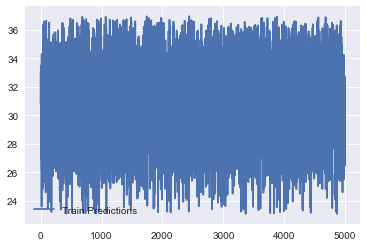

In [20]:
plt.plot(train_results['Train Predictions'][:5000],)
plt.plot(train_results['Actuals'][:5000])
plt.legend(['Train Predictions','Actuals'])